# TUMOR - CNR - TOWARD HISTOGRAM ANALYSIS - TEST FUNCTIONS


Created: 2021.11.06 / Updated: 2021.11.09

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import subprocess as subp
import pathlib
import glob
import shutil
from datetime import date
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import scipy
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import IPython
from scipy import ndimage as ndi

In [4]:
import utils
import functions1 as f1

### GLOBAL VARIABLES

In [5]:
HOME_DIR = pathlib.Path(os.getcwd()).parent
DATA_DIR = HOME_DIR / 'data'
RESULTS_DIR = DATA_DIR / 'results'

SUBJS = ['CC1', 'CC2', 'CC3']

### COLOR MAP

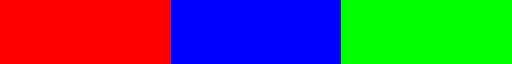

In [6]:
# AD HOC colormap for HD-GLIO  (CE, NE)-segmentation overlay
colors = [(1, 0, 0), (0, 0, 1), (0, 1, 0)]  # R -> B -> G
n_bins = [2, 3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'my_cm'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins[1])
cm

---

## OUR FUNCTIONS

In [7]:
def im_info(im, name='image'):
    """
    The basic info about image.
    
    Parameters:
    ---------------
    im - image,
    name - displayed image name (hepful in multiple use in the row)
    
    C: 2021.11.06 / U:2021.11.06
    """
    print(f'*** {name.upper()} ***,\tmax={im.max()}, min={im.min()}, aver={im.mean():.2f}, shape={im.shape}, dtype={im.dtype}')

In [8]:
def get_voxel_resolution_from_header(hdr, name="Image"):
    """
    Get image resolution and voxel dimesnion based on the header. 
    
    Parameters:
    --------------------
    hdr - header of a Nifti image
    name - name of image (to print as info)
    
    
    Return
    
    C: 2021.11.08 / U:2021.11.08
    """
    img_res = hdr['dim'][1:4]
    vox_size = hdr['pixdim'][1:4]
    print(f'*** {name.upper()} ***')
    print(f'\tImage resolution: {img_res}')
    print(f'\tVoxel size: {vox_size}')
    

In [9]:
def load_nifti_components(file_name):
    """
    Loads NIfTI file, returns its data and structures.
    
    RETURNS:
    ------------------------
    img - loaded image data
    nii - the whole Nifti structure    
    hdr - header
    aff - affine matrix
    
    C: 2021.11.06 / U: 2021.11.06
    """
    nii = nib.load(file_name)
    img = nii.get_fdata()
    hdr = nii.header
    aff = nii.affine
    return img, nii, hdr, aff

In [10]:
def create_rgb(img, roi=None, dil=None, slice=14, verbose=True):
    """
    Create RGB image from selected slices of `img`, `roi` and `dilated roi` images.
    
    Each slice creates single color channel in RGB image:
        R -> dilated mask,
        G -> roi mask,
        B -> image.
    
    C: 2021.11.07 / U: 2021.11.07
    """
    i = img[:,:,slice]
    # rescale to 0-1 if brightness > 1
    if i.max() > 1:
        i = (i - i.min()) / (i.max() - i.min()).astype('float32')
        if verbose: print('Rescaled "img"')
    
    # roi image
    if  isinstance(roi, np.ndarray):
        r = roi[:,:,slice]
        # rescale to 0-1 if brightness > 1
        if r.max() > 1:
            r = (r - r.min()) / (r.max() - r.min()).astype('float32')
            if verbose: print('Rescaled "roi"')
        # convert to boolean values, we will use these matrices as a matrix indices
        r = np.asarray(r, dtype='bool')
        r_mask = i.copy()
        r_mask[r] = 1
    else:
        r_mask = i.copy()
        
    # dil image
    if isinstance(dil, np.ndarray):
        d = dil[:,:,slice]
        # rescale to 0-1 if brightness > 1
        if d.max() > 1:
            d = (d - i.min()) / (d.max() - d.min()).astype('float32');
            if verbose: print('Rescaled "dil"')
        # convert to boolean values, we will use these matrices as a matrix indices 
        d = np.asarray(d, dtype='bool')
        d_mask = i.copy()
        d_mask[d] = 1   
    else:
        d_mask = i.copy()
    
    # prepare 2D RGB image (for selected slice)
    rows, cols, slices = img.shape
    im3 = np.zeros((rows,cols,3), dtype=img.dtype)    
    
    # assemble RGB
    im3[:,:,0] = d_mask
    im3[:,:,1] = r_mask
    im3[:,:,2] = i
    return im3

In [11]:
def show_3_crosssections(img, slices=[], mip=False, figsize=(10,6), cmap='gray', axison=False, fontsize=18, title='Image'):
    """
    Displays 3 cross sections of slices set in slice containter. 
    
    PAREMETERS:
    ------------------------
    img - 3D image,
    slice - tuple or list with 3 indeces to show, if empty the middle slice is selected of each direction,
    mip - if True display Maximum Intensity Projection (MIP), else selected slice given by `slices`,
    fig_size - figure size,
    cmap - color map,
    axison - on/off axis markers,
    fontsize - title fontsize.
    
    C: 2021.11.08 / U:2021.11.08
    """
    
    # image shape
    r,c,s = img.shape
    r2, c2, s2 = int(r//2), int(c//2), int(s//2)
    if not slices:
        rx, cx, sx = r2, c2, s2
    else:
        rx, cx, sx = slicess
    
    f, ax = plt.subplots(1,3, figsize=figsize)
    
    if mip:
        ax[0].imshow(img.max(0), cmap=cmap)
        ax[1].imshow(img.max(1), cmap=cmap)
        ax[2].imshow(img.max(2), cmap=cmap)
        s = 'MIP for dir'
    else:
        ax[0].imshow(img[rx,:,:], cmap=cmap)
        ax[1].imshow(img[:,cx,:], cmap=cmap)
        ax[2].imshow(img[:,:,sx], cmap=cmap)
        s = 'Dir'
    
    for k in range(3):
        if not axison: ax[k].axis('off')
        ax[k].set_title(f'{s} {k}', fontsize=fontsize)
    plt.suptitle(title, fontsize=fontsize+2, fontweight='bold')
    plt.tight_layout()

In [12]:
def crop_image_inside_bigger_mask(img, roi, mask):
    """
    Crop a part of the `img` and `roi` images that are under `mask` (usulally dilated roi).
    
    Parameters:
    -----------------------
    img - 3D image,
    roi - 3D roi image,
    mask - 3D binary mask - usually dilated roi.
    
    
    Return:
    ---------------------------
    cropped images:
        img_c, roi_c, mask_c
    
    C: 2021.11.08 / U: 2021.11.08
    """
    
    xy = mask.max(2)
    #print(xy.shape)
    xy_idx = np.where(xy==1)
    y1max,y1min = xy_idx[0].max(), xy_idx[0].min()
    x1max,x1min = xy_idx[1].max(), xy_idx[1].min()

    xz = mask.max(1)
    #print(xz.shape)
    xz_idx = np.where(xz==1)
    x2max,x2min = xz_idx[0].max(), xz_idx[0].min()
    z2max,z2min = xz_idx[1].max(), xz_idx[1].min()

    # crop images 
    img_c = img[y1min:y1max, x1min:x1max, z2min:z2max]
    roi_c = roi[y1min:y1max, x1min:x1max, z2min:z2max]
    mask_c = mask[y1min:y1max, x1min:x1max, z2min:z2max]
    
    return img_c, roi_c, mask_c

In [13]:
def get_image_under_single_mask(img, mask, crop=False):
    """
    Get image from inside of a single mask. If crop=True, return cropped image to the mask dimensions.
    
    C: 2021.11.09 / U: 2021.11.09
    """
    
    if crop:
        xy = mask.max(2)
        #print(xy.shape)
        xy_idx = np.where(xy==1)
        y1max,y1min = xy_idx[0].max(), xy_idx[0].min()
        x1max,x1min = xy_idx[1].max(), xy_idx[1].min()

        xz = mask.max(1)
        #print(xz.shape)
        xz_idx = np.where(xz==1)
        x2max,x2min = xz_idx[0].max(), xz_idx[0].min()
        z2max,z2min = xz_idx[1].max(), xz_idx[1].min()
        
        return img[y1min:y1max, x1min:x1max, z2min:z2max]
    else:
        return np.where(mask, img, 0)

In [14]:
def show_image(img, title='title', fig_size=(18,12), fontsize=16, cmap='gray'):
    """
    Shows image (also RGB) thet was created by `create_rgb()` function.
    
    C: 2021.11.07 / U: 2021.11.09
    """    
    f,ax = plt.subplots(figsize=fig_size)
    plt.imshow(img, cmap=cmap)
    plt.title(title, fontsize=fontsize, fontweight='bold') 
    plt.show()

In [15]:
def show_2_images(im1, im2, mip=False, slice=None, figsize=(16,12),
                  title='2 Images', title_im1='Image1', title_im2='Image2', fontsize=16, cmap='gray'):
    """
    Displays selected slices or MIPs of 2 3D images.
    
    C: 2021.11.09 / U: 2021.11.09
    """
    sl = slice if slice else int(im1.shape[2]//2)
    
    f, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize=figsize)
    if mip:
        ax[0].imshow(im1.max(2), cmap=cmap)
        ax[1].imshow(im2.max(2), cmap=cmap)
        s = '(MIP)'
    else:
        ax[0].imshow(im1[:,:,sl], cmap=cmap)
        ax[1].imshow(im2[:,:,sl], cmap=cmap)
        s = f'(sl={sl})'
    ax[0].set_title(f'{title_im1} {s}', fontsize=fontsize)
    ax[1].set_title(f'{title_im2} {s}', fontsize=fontsize)
    
   
    plt.suptitle(title, fontsize=fontsize+2, fontweight='bold')
    plt.tight_layout()
    plt.show()    

In [16]:
def show_overlaied_slices_in_3d_images(ic, rc, dc, rows=4, cols=5, fontsize=18, figsize=(24,20)):
    """
    Show all slices as RGB images from the dilated ROIs overimposed on the image.
    
    C: 2021.11.08 / 2021.11.08
    """
    f, ax = plt.subplots(rows,cols,sharex=True, sharey=True, figsize=figsize)
    axf=ax.flat[:]

    for sl in range(ic.shape[2]):
        icrgb = create_rgb(ic, rc, dc, slice=sl, verbose=False)
        axf[sl].imshow(icrgb)
        axf[sl].set_title(f'sl={sl}', fontsize=fontsize)

    for k in range(ic.shape[2]+1, rows*cols+1):
        axf[k-1].set_axis_off()

    _=plt.suptitle(f'Consequtive slices of overimopsed masks over image', fontsize=fontsize+4, fontweight='bold')
    plt.tight_layout()

In [17]:
def plot_2_histograms(insight, rim, bins=128, figsize=(22,16), fontsize=25, title='Histograms of "insight" and "rim" images', legendloc=0):
    """
    Plots histograms of two images: insight and rim
    
    C: 2021.11.09 / U: 2021.11.09
    """
    # remove zeros from the images
    insight = insight[insight>0]
    rim = rim[rim>0]

    f, ax = plt.subplots(1,1,figsize=(22,16))
    _ = ax.hist(insight.flat[:], bins, alpha=0.9, label='insight', color='red')
    _ = ax.hist(rim.flat[:], bins, alpha=0.5, label='rim', color='blue')
    ax.set_title(title, fontsize=fontsize, fontweight='bold')
    #ax.set_ylim(top=1000)
    ax.legend(fontsize=fontsize-4, loc=legendloc)
    
    plt.grid(True)

---

# SELECT A SUBJECT

In [18]:
subj='CC1'

## LOAD T2 IMAGE

In [19]:
file_img = f'{RESULTS_DIR}/{subj}_t2.nii.gz'
img, img_nii, img_header, img_affine = load_nifti_components(file_img)

#### PRINT INFO ABOUT LOADED `CC1-T2` IMAGE

In [20]:
im_info(img, name=subj)

*** CC1 ***,	max=988.0, min=0.0, aver=252.81, shape=(320, 320, 25), dtype=float64


In [21]:
# print out image resolution and voxel size
get_voxel_resolution_from_header(img_header, subj)

*** CC1 ***
	Image resolution: [320 320  25]
	Voxel size: [0.5625 0.5625 3.    ]


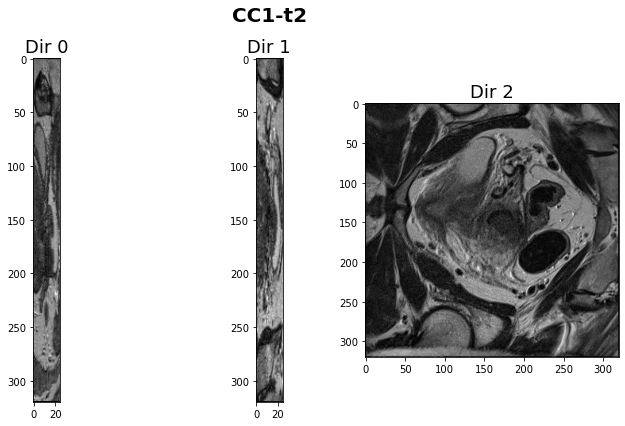

In [22]:
show_3_crosssections(img, figsize=(10,6),axison=True, title='CC1-t2')

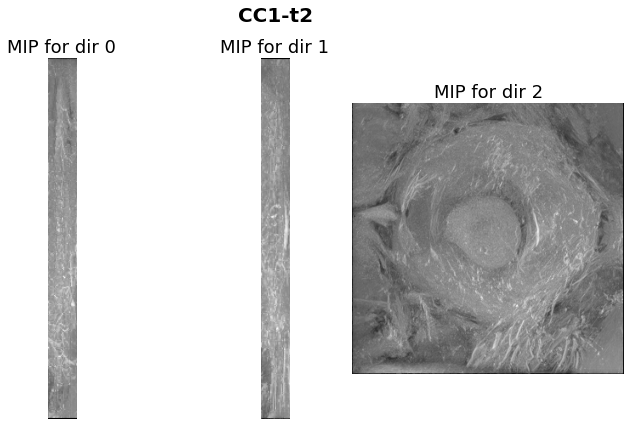

In [23]:
show_3_crosssections(img, figsize=(10,6), mip=True, title='CC1-t2')

## LOAD T2 ROI (`mask3d`)

In [24]:
file_roi = f'{RESULTS_DIR}/{subj}_t2_roi.nii.gz'
mask3d, roi_nii, roi_header, roi_affine = load_nifti_components(file_roi)
im_info(mask3d, name='roi')

*** ROI ***,	max=1.0, min=0.0, aver=0.00, shape=(320, 320, 25), dtype=float64


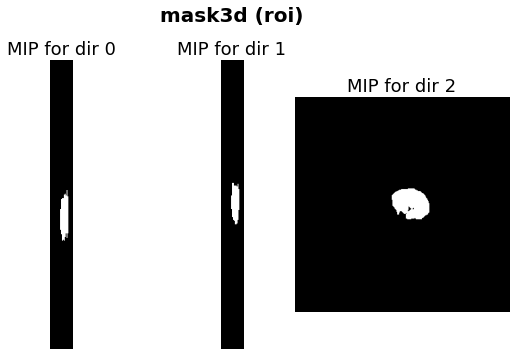

In [25]:
show_3_crosssections(mask3d, figsize=(8,5), axison=False, mip=True, title='mask3d (roi)')

## LOAD CENTER OF MASS IMAGE

*** CM ***,	max=255.0, min=0.0, aver=0.00, shape=(320, 320, 25), dtype=float64


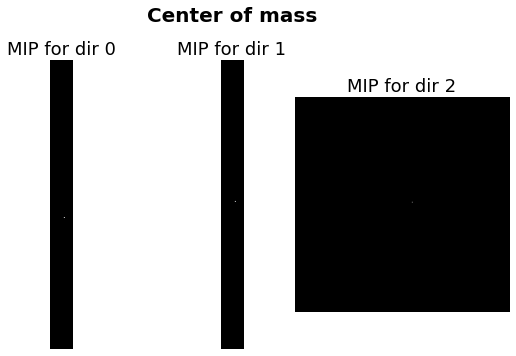

In [26]:
file_cm = f'{RESULTS_DIR}/{subj}_t2_roi_cm.nii.gz'
cm, cm_nii, cm_header, cm_affine = load_nifti_components(file_cm)
im_info(cm, name='cm')
show_3_crosssections(cm, figsize=(8,5), axison=False, mip=True, title='Center of mass')

# DILATED IMAGE(S)

## DILATED - BALL 5

In [27]:
file_dil = f'{RESULTS_DIR}/{subj}_t2_roi_dilated_ball5.nii.gz'
dil5, dil_nii, dil_header, dil_affine = load_nifti_components(file_dil)
im_info(dil5, name='dil5')

*** DIL5 ***,	max=1.0, min=0.0, aver=0.02, shape=(320, 320, 25), dtype=float64


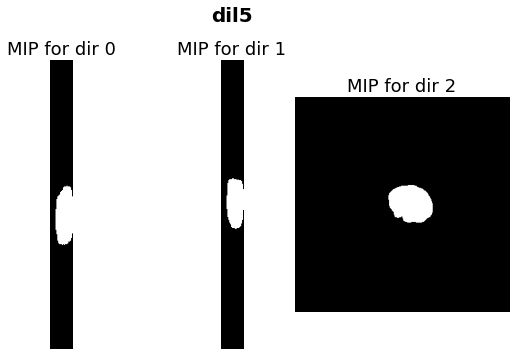

In [28]:
show_3_crosssections(dil5, figsize=(8,5), axison=False, mip=True, title='dil5')

---

# OVERLAY IMAGE WITH MASKS: ROI & DIL5

Extract selected slice from `img`, `mask3d` and `dil5` images and create 3-channel (RGB) image to present overlayed regions of interests (ROIs).

In [29]:
img3 = create_rgb(img, mask3d, dil5, slice=14)

Rescaled "img"


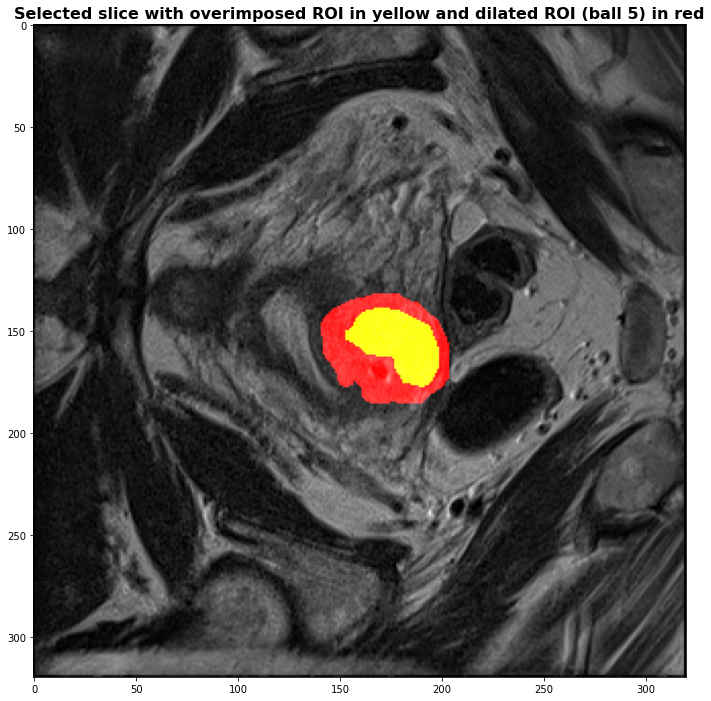

In [30]:
title = 'Selected slice with overimposed ROI in yellow and dilated ROI (ball 5) in red'
show_image(img3, title)

# CROP REGION OF INTEREST 

Cropped region is restricted by 'bigger' mask (e.g. dil5 image).

In [31]:
# image cropped, roi cropped, dil5 cropped
ic, rc, dc = crop_image_inside_bigger_mask(img, mask3d, dil5)

### Display image cross-sections

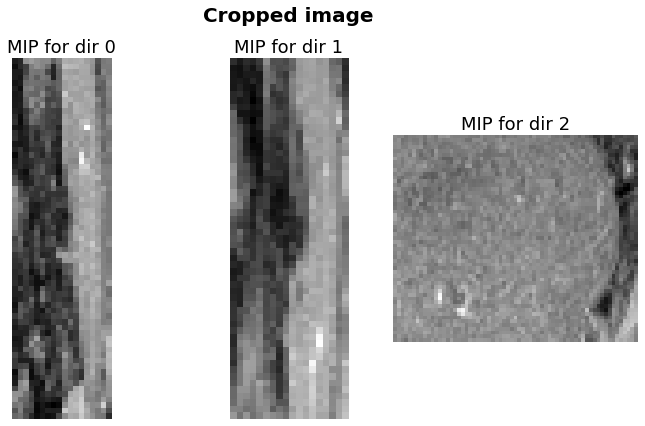

In [32]:
# MIP of the image
show_3_crosssections(ic, mip=True, title='Cropped image')

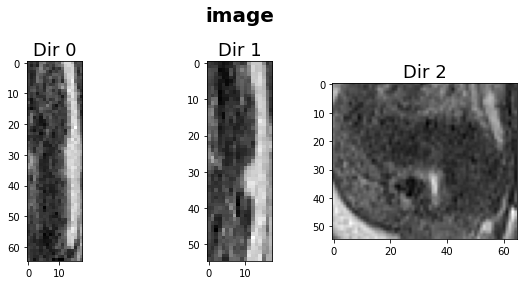

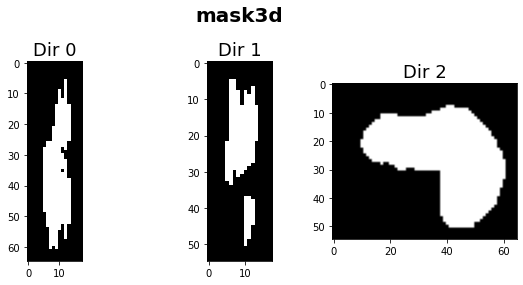

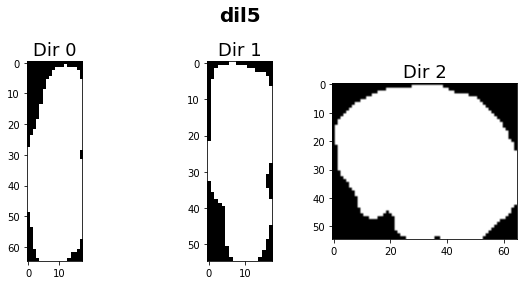

In [33]:
# crossections of all cropped images (image, roi, dil5)
names = ['image', 'mask3d', 'dil5']
for k, im in enumerate([ic, rc, dc]):
    show_3_crosssections(im, axison=1, figsize=(8,4), title=names[k])

### Display overlayed cropped image

Rescaled "img"


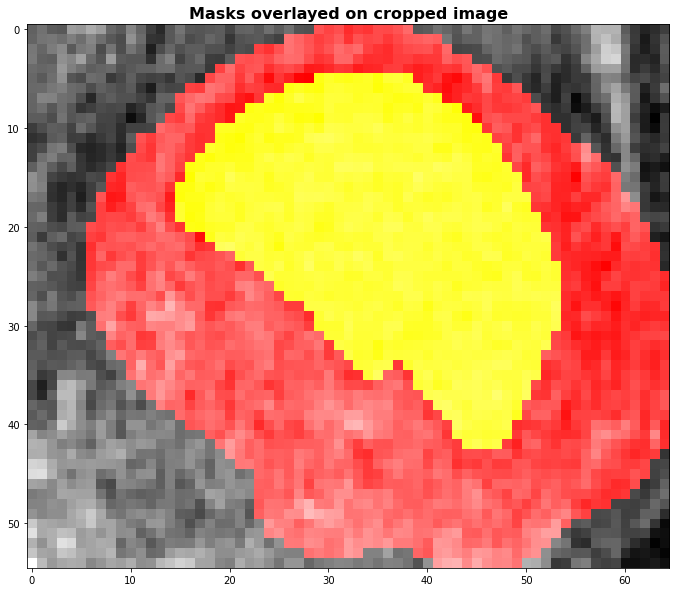

In [34]:
icrgb = create_rgb(ic, rc, dc, slice = 6)
show_image(icrgb, title='Masks overlayed on cropped image', fig_size=(16,10))

# Show all cropped image slices with overimposed ROIs

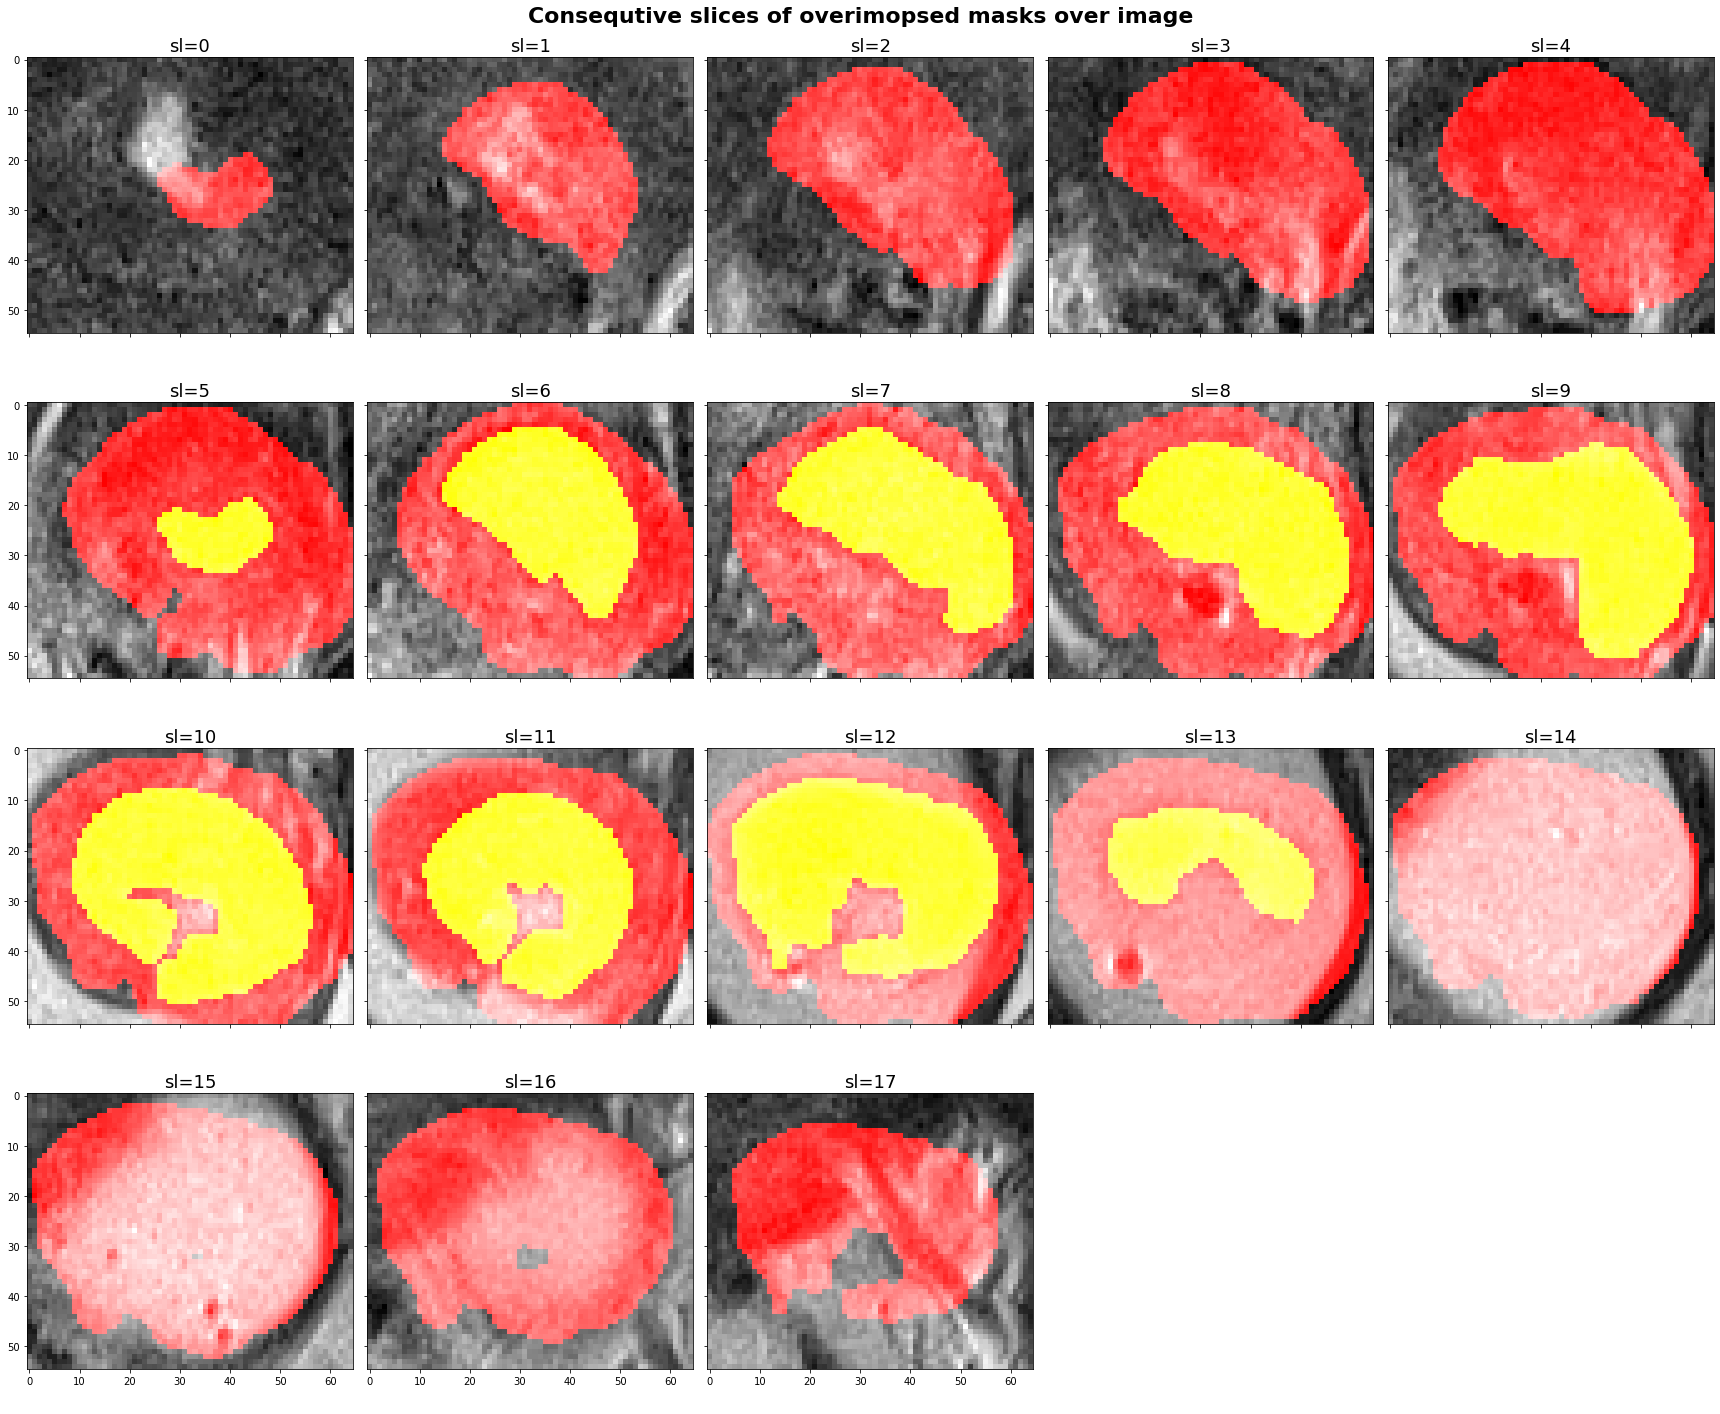

In [35]:
show_overlaied_slices_in_3d_images(ic,rc,dc)

---

# HISTOGRAMS

In [36]:
# get voxels inside dil5 roi
a = img[dil5==1]
im_info(a,'im-dil5')

*** IM-DIL5 ***,	max=801.0, min=0.0, aver=256.69, shape=(38796,), dtype=float64


In [37]:
# get voxels inside roi mask
b = img[mask3d==1]
im_info(b, 'im-roi')

*** IM-ROI ***,	max=507.0, min=0.0, aver=168.94, shape=(9180,), dtype=float64


In [38]:
# get image inside roi
a = np.where(mask3d,img,0)
im_info(a, name='inside roi')

*** INSIDE ROI ***,	max=507.0, min=0.0, aver=0.61, shape=(320, 320, 25), dtype=float64


In [39]:
# get image inside dil5 mask
b = np.where(dil5,img,0)
im_info(b, name='inside dil5 mask')

*** INSIDE DIL5 MASK ***,	max=801.0, min=0.0, aver=3.89, shape=(320, 320, 25), dtype=float64


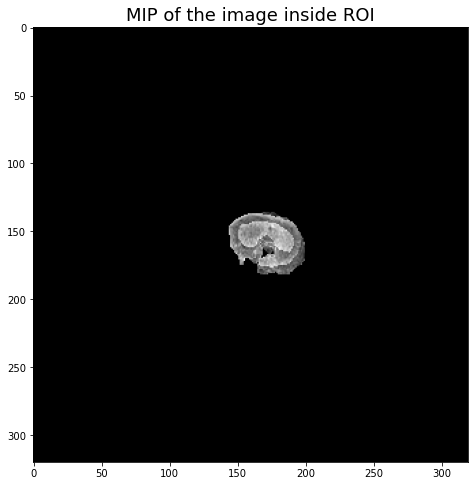

In [40]:
plt.figure(figsize=(14,8))
plt.imshow(a.max(2), cmap='gray')
_ = plt.title('MIP of the image inside ROI', fontsize=18)

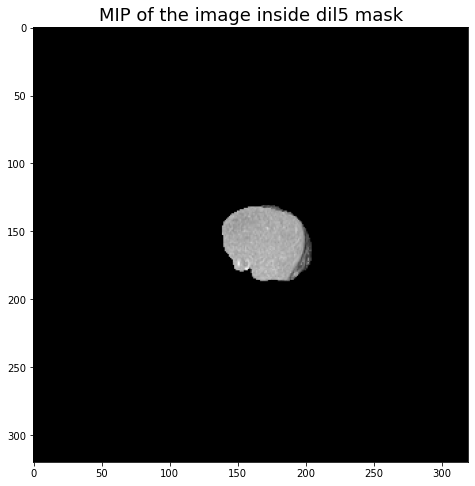

In [41]:
plt.figure(figsize=(14,8))
plt.imshow(b.max(2), cmap='gray')
_ = plt.title('MIP of the image inside dil5 mask', fontsize=18)

*** IMG-ROI ***,	max=507.0, min=0.0, aver=0.61, shape=(320, 320, 25), dtype=float64
*** IMG-ROI-DIL5 ***,	max=507.0, min=0.0, aver=24.10, shape=(55, 65, 18), dtype=float64
*** IMAGE ***,	max=801.0, min=0.0, aver=251.84, shape=(55, 65, 18), dtype=float64


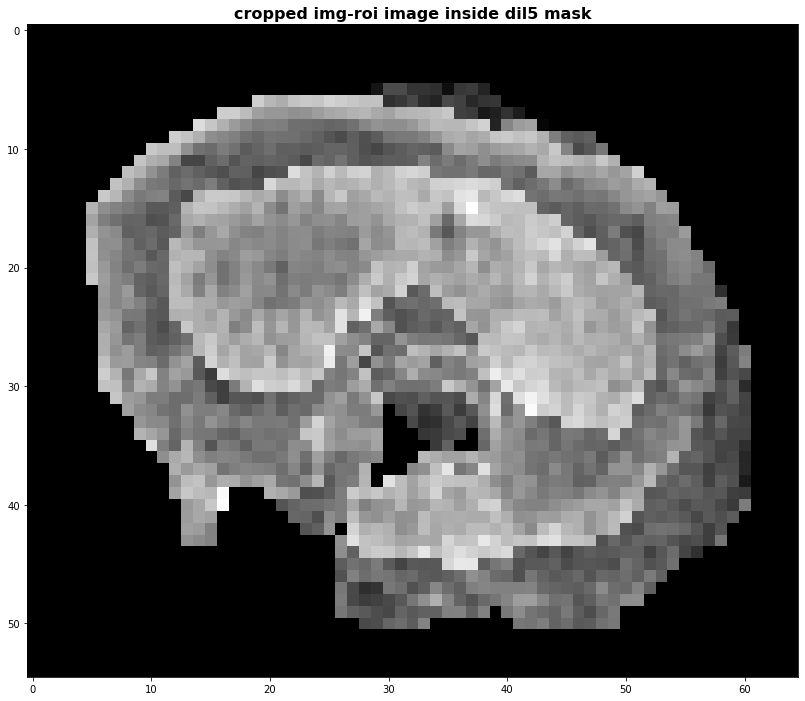

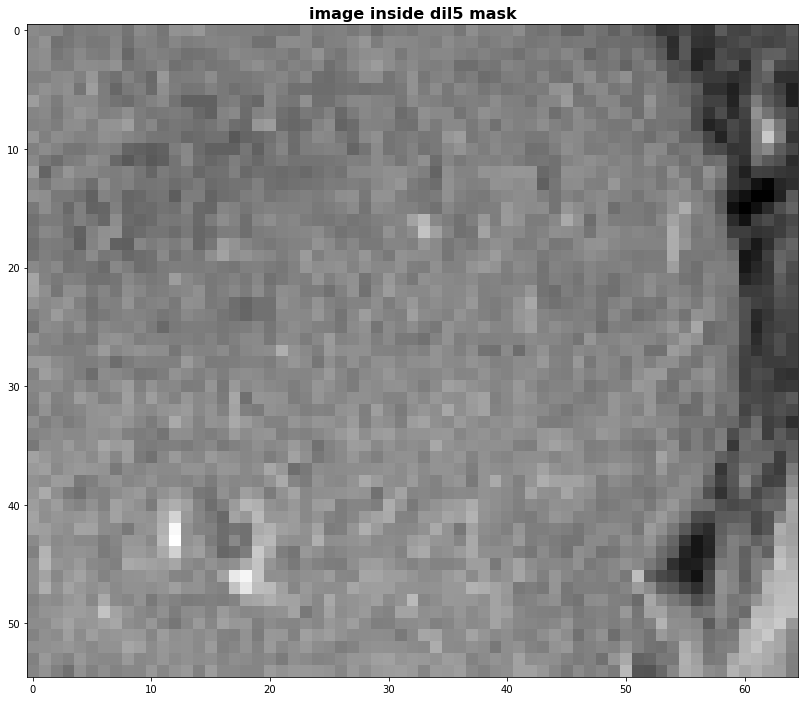

In [42]:
# full image inside roi
img_roi = get_image_under_single_mask(img,mask3d, crop=False)
im_info(img_roi, 'img-roi')

# image inside roi under dil5 mask
img_roi_dil5 = get_image_under_single_mask(img_roi, dil5, crop=True)
im_info(img_roi_dil5, 'img-roi-dil5')

# image inside dil5 mask
img_dil5 = get_image_under_single_mask(img, dil5, crop=True)
im_info(img_dil5)

#show_image(img_roi.max(2), title='image inside roi mask')
show_image(img_roi_dil5.max(2), title='cropped img-roi image inside dil5 mask') 
show_image(img_dil5.max(2), title='image inside dil5 mask')

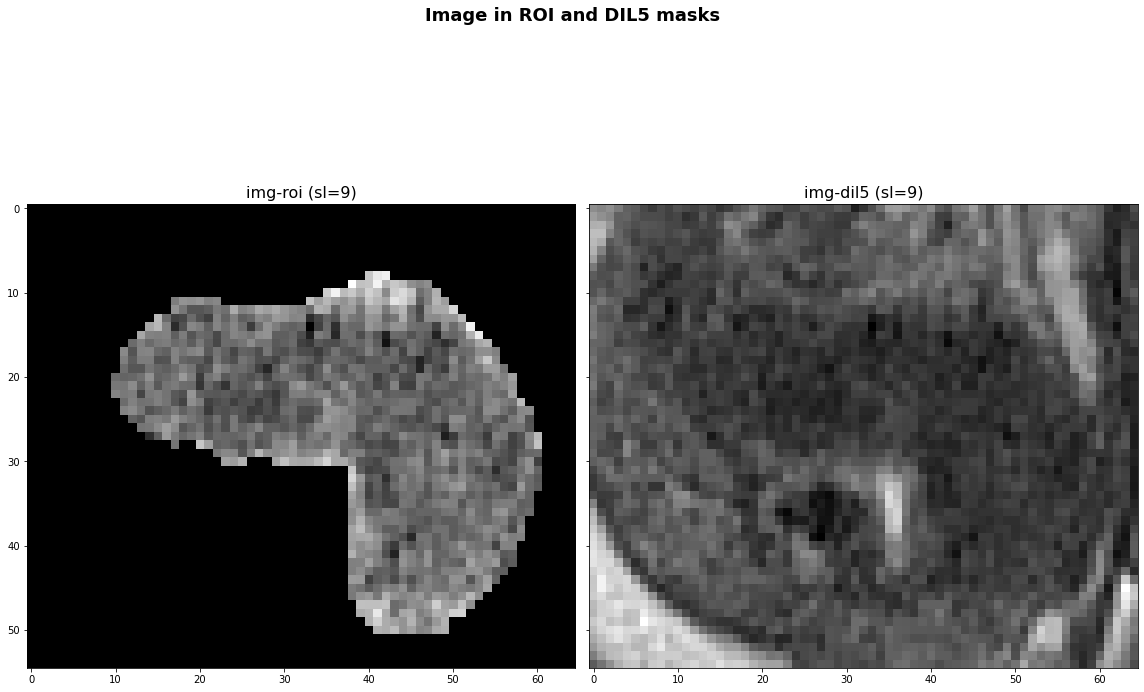

In [43]:
show_2_images(img_roi_dil5, img_dil5, mip=0, title='Image in ROI and DIL5 masks', title_im1='img-roi', title_im2='img-dil5', slice=9)

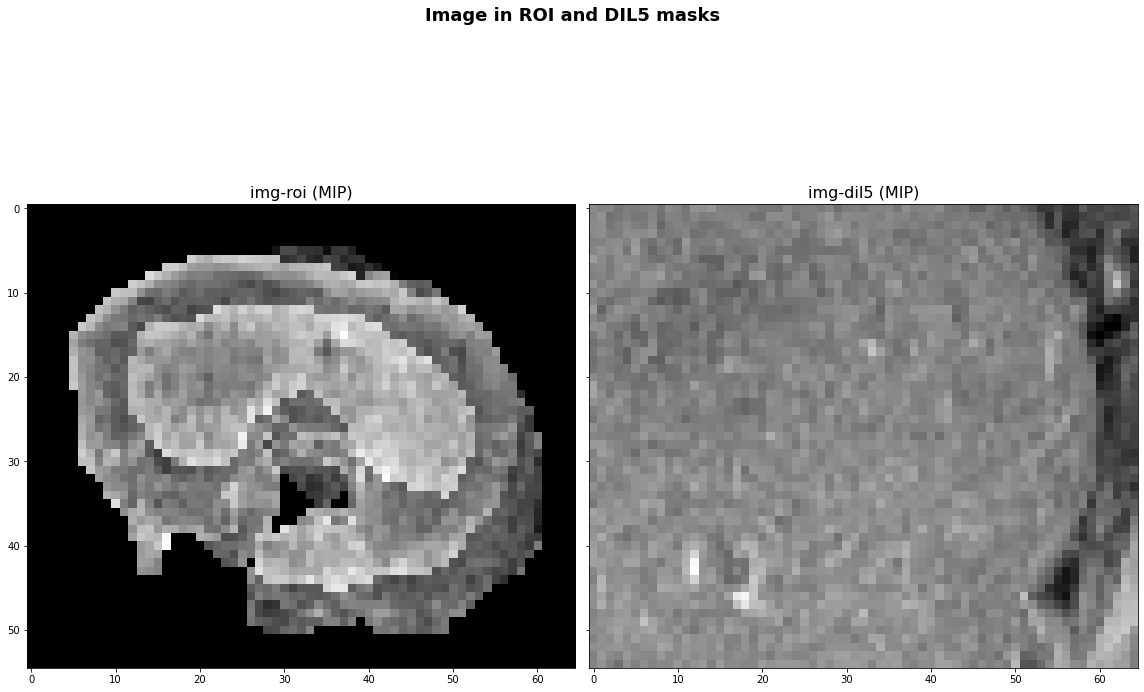

In [44]:
show_2_images(img_roi_dil5, img_dil5, mip=True, title='Image in ROI and DIL5 masks', title_im1='img-roi', title_im2='img-dil5', slice=9)

----

# RIM EXTRACTION

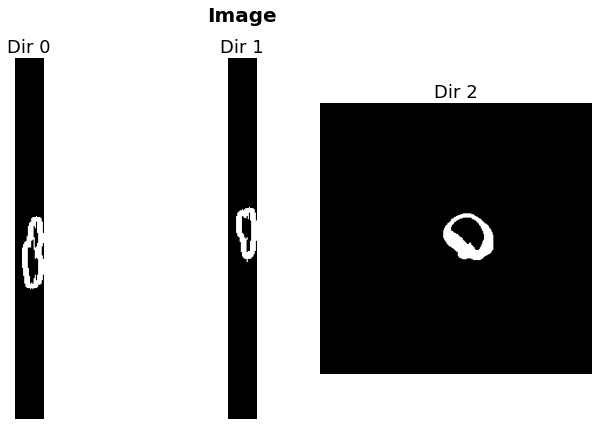

In [45]:
#mask_final = dil5 - np.logical_and(mask3d, dil5)
mask_final = dil5 - mask3d

show_3_crosssections(mask_final)

In [46]:
# CROPPED IMAGES NR 2
# to ged cropped mask_final as mf2
ic2, rc2, mf2 = crop_image_inside_bigger_mask(img, mask3d, mask_final)

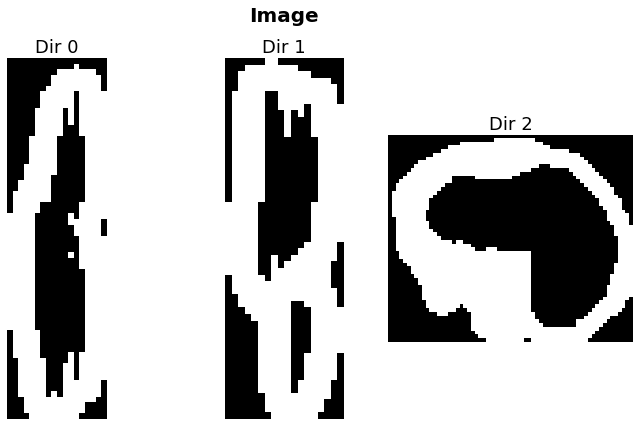

In [47]:
show_3_crosssections(mf2)

### SHOW RIM

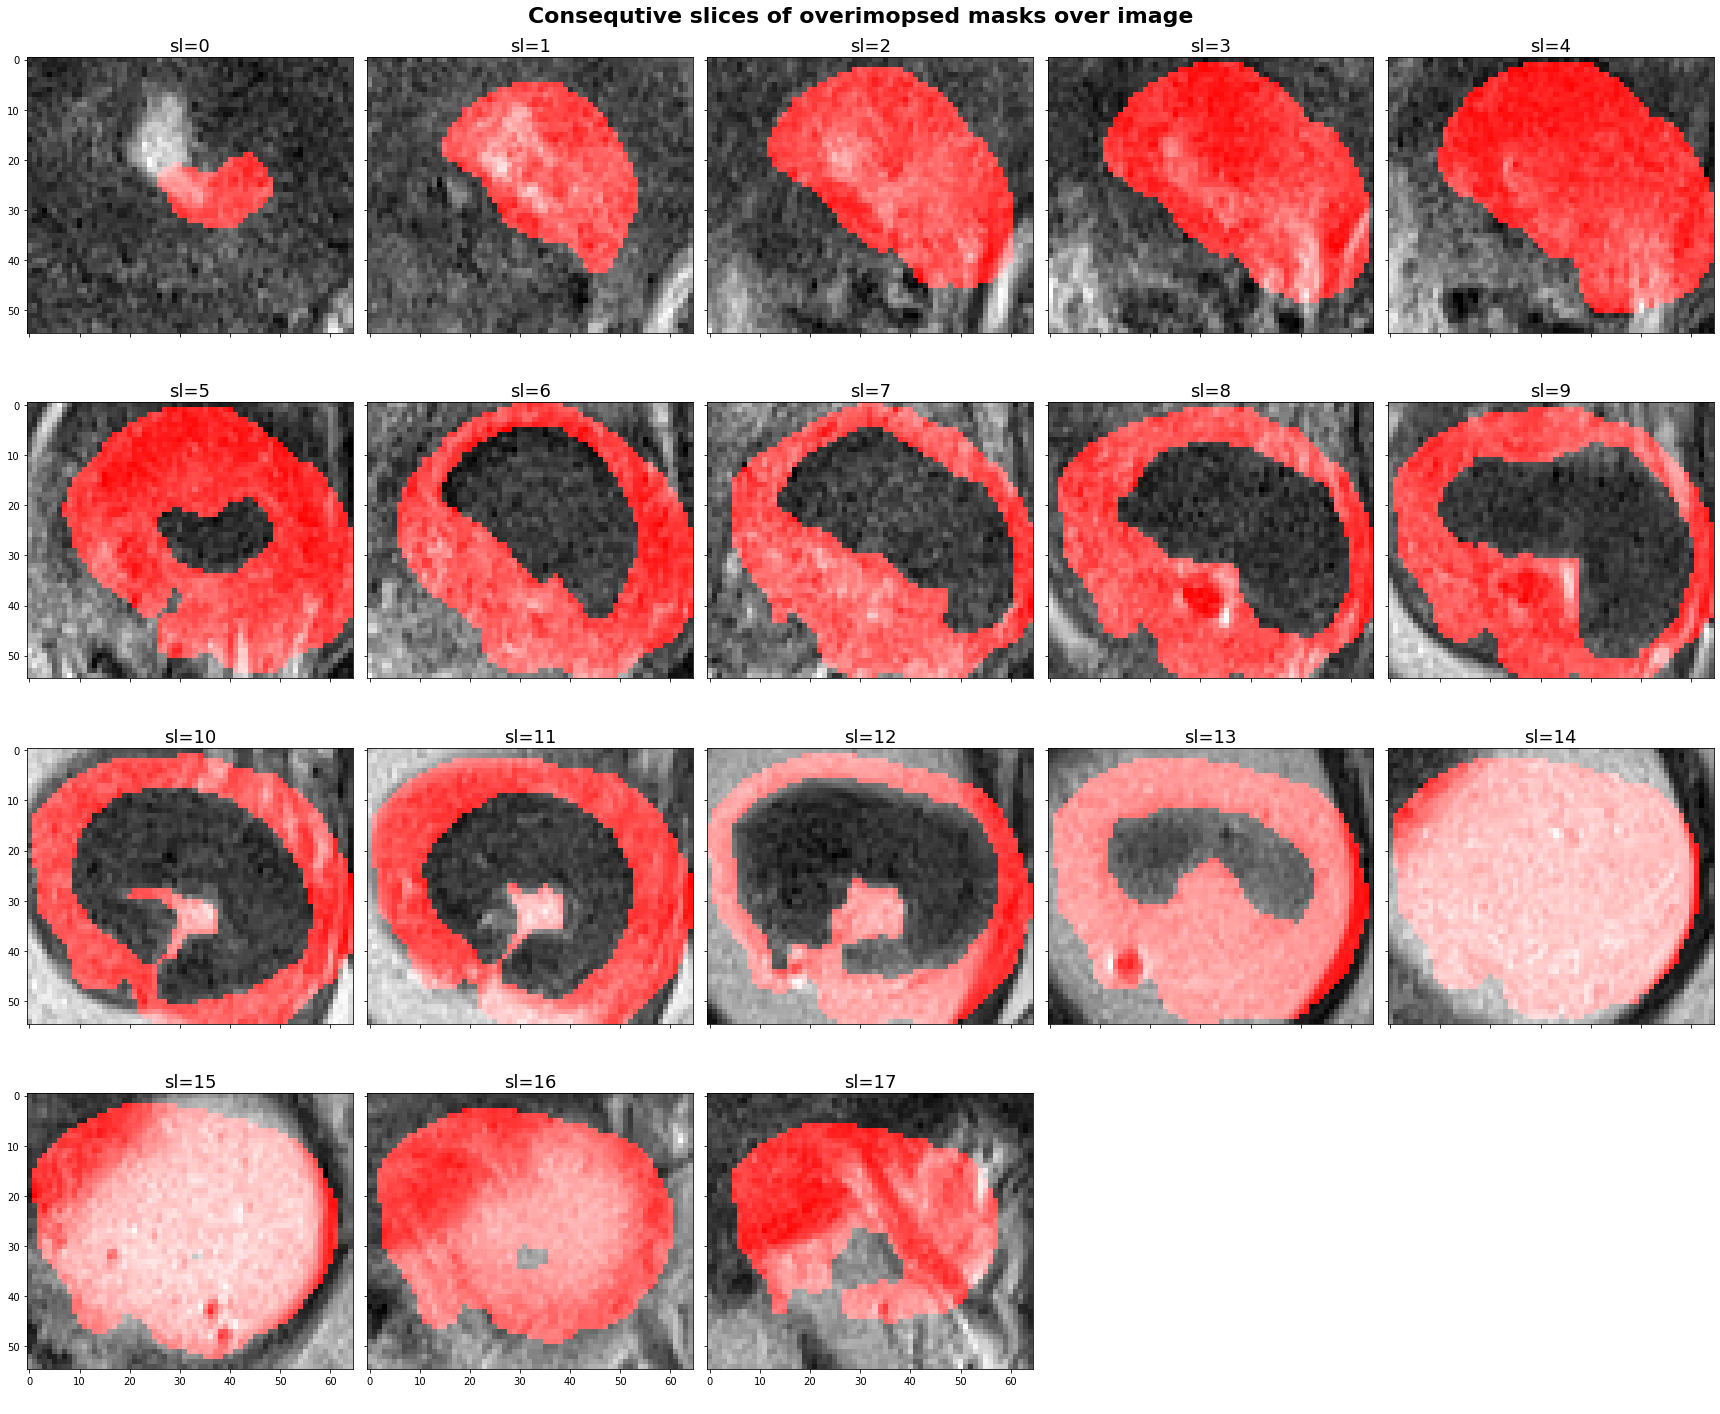

In [48]:
show_overlaied_slices_in_3d_images(ic,rc=None,dc=mf2)

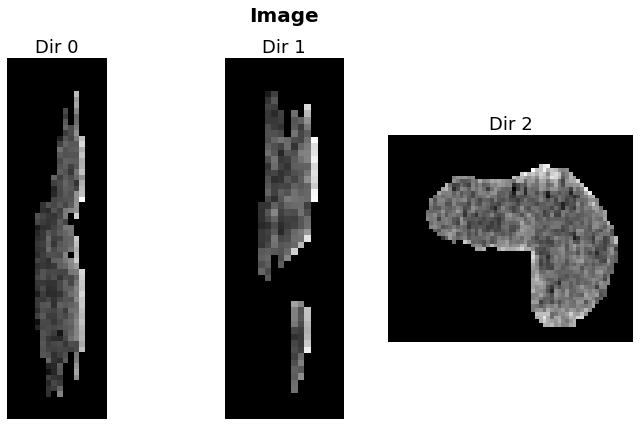

In [49]:
show_3_crosssections(img_roi_dil5)

# GET IMAGE UNDER RIM

In [50]:
rim = np.where(mf2,ic,0)

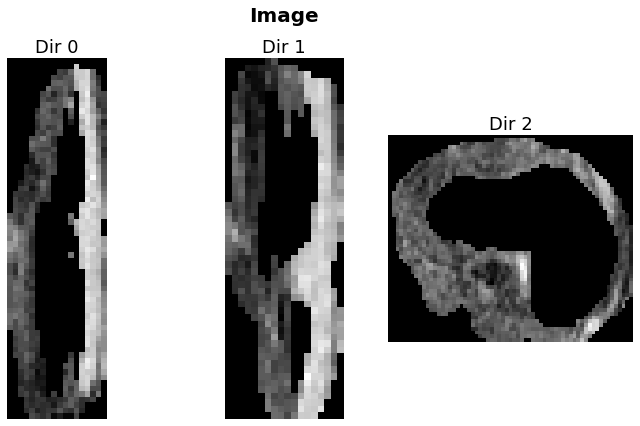

In [51]:
show_3_crosssections(rim)

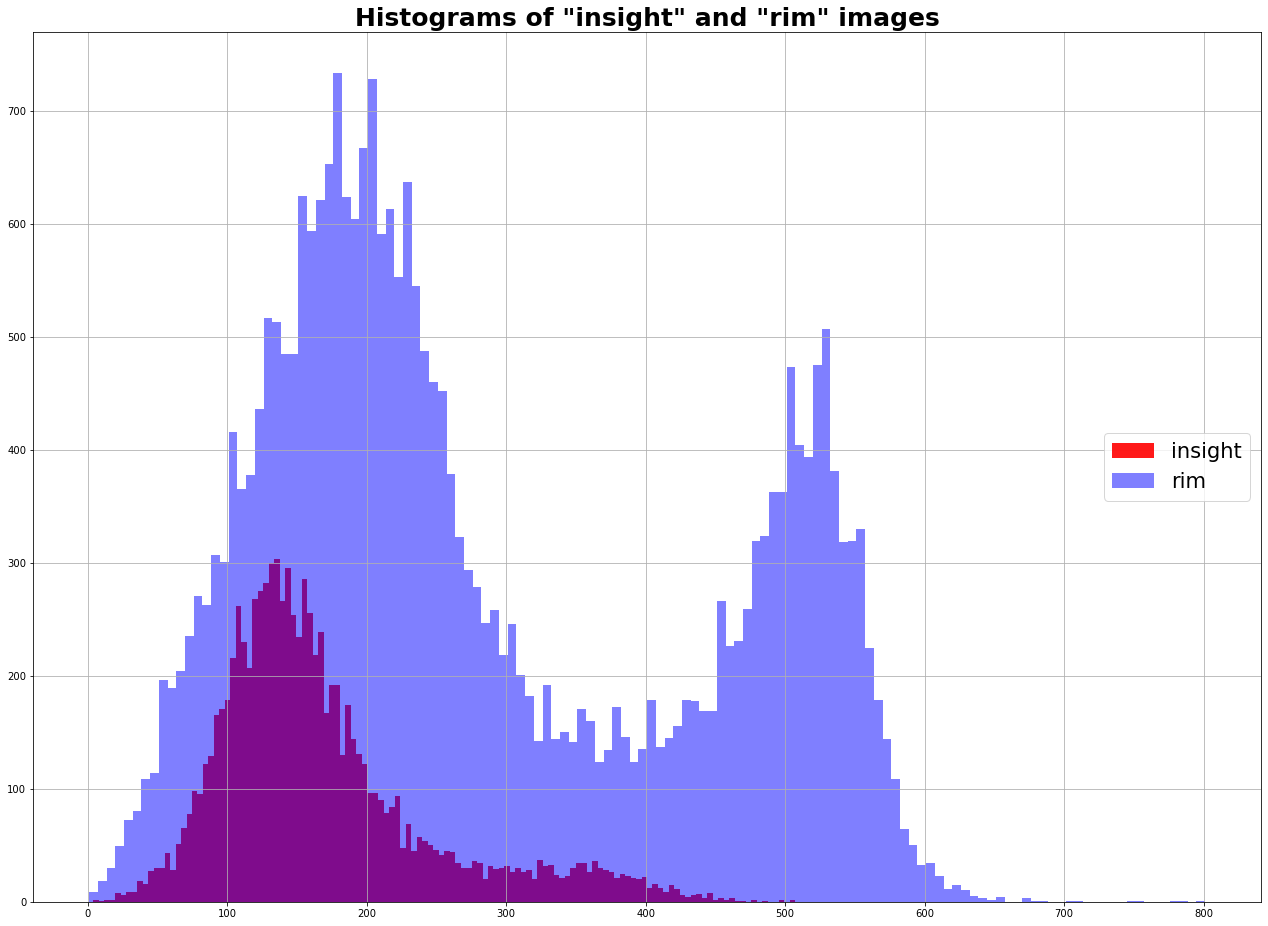

In [52]:
plot_2_histograms(img_roi_dil5, rim, legendloc=7)

---

### to do:
1. funkcja do zapisau macierzy jako nifti wraz z kopiowaniem struktury nii

In [53]:
ls $RESULTS_DIR

CC1_t2_bladder.nii.gz            CC2_t2_roi_dilated2.nii.gz
CC1_t2.json                      CC2_t2_roi_dilated_ball3.nii.gz
CC1_t2.nii.gz                    CC2_t2_roi.json
CC1_t2_roi_cm.nii.gz             CC2_t2_roi.nii.gz
CC1_t2_roi_dilated1.nii.gz       CC3_t2_bladder.nii.gz
CC1_t2_roi_dilated2.nii.gz       CC3_t2.json
CC1_t2_roi_dilated_ball2.nii.gz  CC3_t2.nii.gz
CC1_t2_roi_dilated_ball3.nii.gz  CC3_t2_roi_cm.nii.gz
CC1_t2_roi_dilated_ball5.nii.gz  CC3_t2_roi_dilated2.nii.gz
CC1_t2_roi.json                  CC3_t2_roi_dilated_ball3.nii.gz
CC1_t2_roi.nii.gz                CC3_t2_roi.json
CC2_t2_bladder.nii.gz            CC3_t2_roi.nii.gz
CC2_t2.json                      CC3_t2_roi.vtk
CC2_t2.nii.gz                    CC3_t2.vtk
CC2_t2_roi_cm.nii.gz


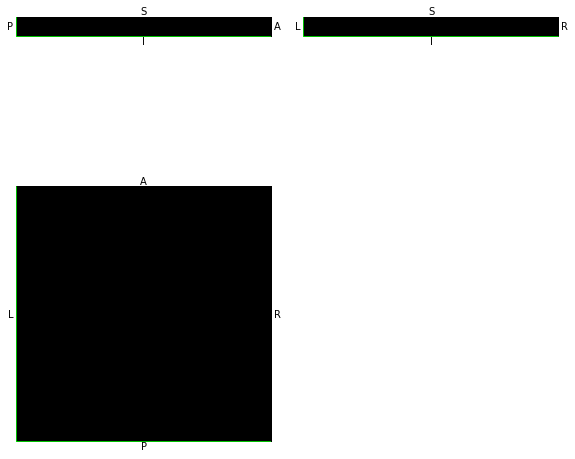

In [54]:
OrthoSlicer3D(a).show()

In [55]:
def imshow_orthogonal(im):
    cmap = 'gray'
    f,ax = plt.subplots(1,3, figsize=(18,12))
    for k in range(3):
        ax[k].imshow(im.max(k), cmap=cmap)
        ax[k].set_title(f'MIP for {k} dir')

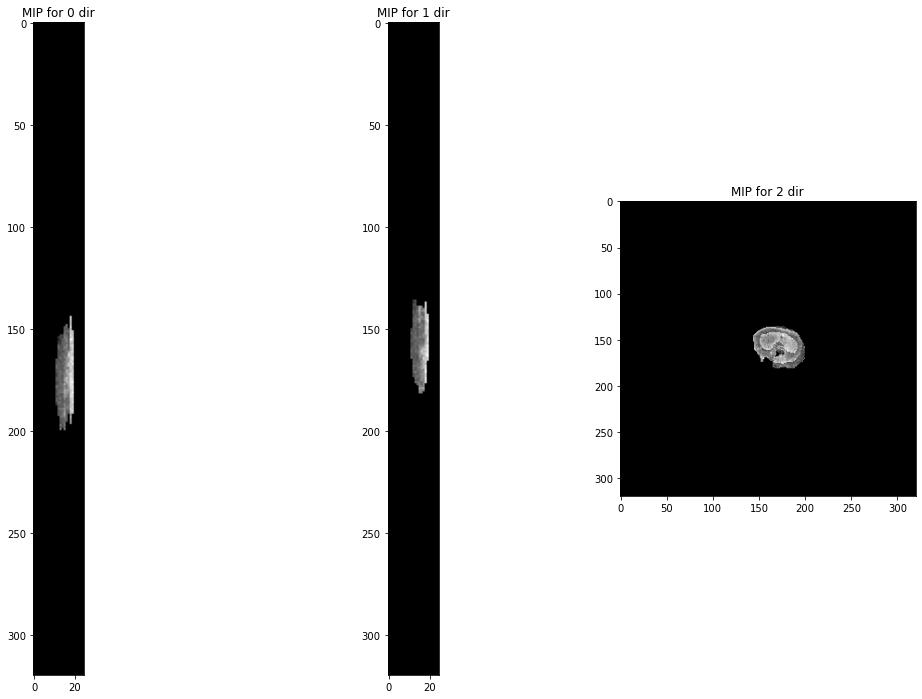

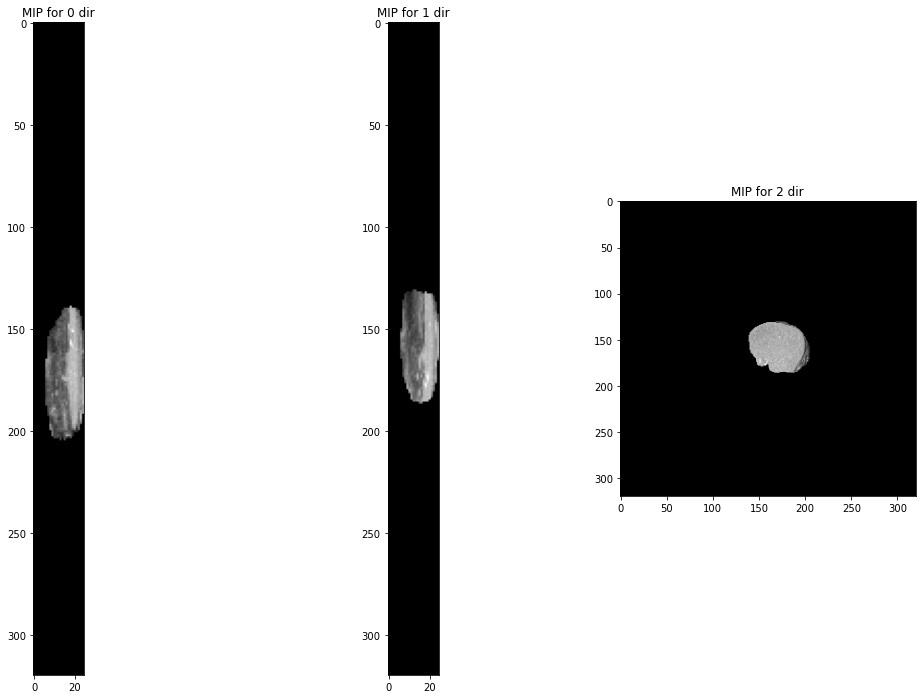

In [56]:
imshow_orthogonal(a)
imshow_orthogonal(b)

In [57]:
utils.print_date(5)

28-Nov-2021 15:06:33


In [59]:
utils.save_notebook_as_html(file_name='cnr-04-histogram-tests', cleaning_delay=2)